### 1. 初始化

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()   

In [2]:
#导入库
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

### 2. 数据预处理

In [27]:
#预览数据格式
a = pd.read_csv("dapp_active_number.csv",index_col='id')
a.sample(5)

,date,DODO,Open_sea,Uniswap,Oasis_app,Shiba_swap,BRAVE_FRONTIER_HEROES,Axie_infinity,HEX,Rarible,...,The_crypto_dads,Fork_delta,dice2_win,ox_universe,Etheroll,Ethereum_name_service,Oasis_trade,Decentraland,Curve,ox_protocol
id,,,,,,,,,,,,,,,,,,,,,
1460,2020-05-12,NaN,247.0,NaN,NaN,NaN,NaN,120.0,1088.0,34.0,...,NaN,98.0,NaN,19.0,4.0,NaN,NaN,56.0,46.0,NaN
2059,2022-01-01,641.0,36699.0,6550.0,NaN,4076.0,NaN,1627.0,2961.0,108.0,...,26.0,9.0,NaN,NaN,NaN,NaN,NaN,65.0,1172.0,NaN
2219,2022-06-10,419.0,NaN,2081.0,NaN,1788.0,NaN,151.0,584.0,44.0,...,1.0,4.0,NaN,NaN,NaN,NaN,NaN,33.0,644.0,NaN
1657,2020-11-25,3591.0,371.0,32823.0,NaN,1.0,NaN,1840.0,1163.0,686.0,...,NaN,90.0,NaN,6.0,NaN,NaN,NaN,37.0,987.0,NaN
404,2017-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,272.0,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN


In [23]:
#书写数据处理函数，提取特征
def read_sum(file_path,attribute):
    data = pd.read_csv(file_path,index_col='id')
    data.drop('date',axis=1,inplace = True)
    data = data.T
    sum = attribute + '_sum'
    std = attribute + '_std'
    data[sum] = data.apply(lambda x: x.sum(), axis=1)
    data[std] = data.apply(lambda x: x.std(), axis=1)
    data = data.iloc[:,2220:].copy()
    return data

In [26]:
#测试函数
a = read_sum("dapp_active_number.csv","active_number")
a.head(3)

id,active_number_sum,active_number_std
DODO,1104015.0,39496.102589
Open_sea,7089117.0,177293.039458
Uniswap,19956899.0,720385.937972


In [31]:
#将4个csv进行整合，合并项为id
active_number = read_sum("dapp_active_number.csv","active_number")
gas = read_sum("dapp_sum_gas.csv","gas")
value = read_sum("dapp_sum_value.csv","value")
transaction = read_sum("dapp_transaction_number.csv","transaction_number")
summary = active_number.copy()
summary = summary.join(gas)
summary = summary.join(value)
summary = summary.join(transaction)
summary

id,active_number_sum,active_number_std,gas_sum,gas_std,value_sum,value_std,transaction_number_sum,transaction_number_std
DODO,1104015.0,39496.102589,2.421677e+22,8.670192e+20,4.886562e+05,1.763201e+04,1383976.0,49500.307659
Open_sea,7089117.0,177293.039458,2.613971e+23,6.540844e+21,6.665434e+06,1.669109e+05,2128244.0,53159.995324
Uniswap,19956899.0,720385.937972,7.483035e+23,2.702839e+22,8.511813e+07,3.077757e+06,4192337.0,151282.352600
Oasis_app,43.0,7.552967,9.290407e+17,1.694427e+17,0.000000e+00,0.000000e+00,68.0,11.929452
Shiba_swap,2866430.0,114577.995420,2.762618e+22,1.106867e+21,2.019185e+02,8.258484e+00,1743709.0,69610.345335
BRAVE_FRONTIER_HEROES,0.0,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN
Axie_infinity,3177851.0,80206.613781,3.815891e+22,9.626076e+20,1.570010e+06,3.977239e+04,2175243.0,54794.945241
HEX,906962.0,29833.009017,9.659310e+21,3.177882e+20,2.367035e+06,7.797371e+04,1129160.0,37132.720825
Rarible,537728.0,17694.297970,1.347848e+22,4.440809e+20,1.242841e+05,4.095589e+03,721197.0,23718.037709
Para_swap_io,125752.0,4589.624788,3.293332e+21,1.202246e+20,9.635499e+05,3.525034e+04,177689.0,6482.181668


In [37]:
# 缺失值处理
summary.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

# 数据标准化
#第一种方法
#from sklearn import preprocessing
#zscore_scaler = preprocessing.StandardScaler()  # 建立StandardScaler对象
#data_scale_1 = zscore_scaler.fit_transform(summary)  # StandardScaler标准化处理
#data_scale_1

#第二种方法
z_score1 = (summary-summary.mean())/summary.std()
z_score2 = summary.apply(lambda x:(x-x.mean())/x.std())
z_score2

id,active_number_sum,active_number_std,gas_sum,gas_std,value_sum,value_std,transaction_number_sum,transaction_number_std
DODO,-0.180677,-0.141251,-0.192666,-0.168807,-0.256726,-0.242553,0.304282,0.484572
Open_sea,1.158003,0.733043,1.218200,0.787357,0.078852,-0.018480,0.974931,0.586944
Uniswap,4.036123,4.178859,4.114562,4.239957,4.341107,4.350808,2.834858,3.331690
Oasis_app,-0.427601,-0.391798,-0.336714,-0.314890,-0.283274,-0.269019,-0.942739,-0.899751
Shiba_swap,0.213520,0.335129,-0.172385,-0.128388,-0.283263,-0.269007,0.628432,1.047104
Axie_infinity,0.283175,0.117049,-0.109731,-0.152698,-0.197977,-0.209320,1.017282,0.632678
HEX,-0.224752,-0.202561,-0.279261,-0.261365,-0.154675,-0.151978,0.074670,0.138618
Rarible,-0.307338,-0.279579,-0.256543,-0.240082,-0.276522,-0.262872,-0.292939,-0.236627
Para_swap_io,-0.399484,-0.362726,-0.317129,-0.294658,-0.230925,-0.216107,-0.782687,-0.718761
Crypto_kitties,-0.294900,-0.299284,-0.275569,-0.272072,-0.276664,-0.264484,0.996155,0.575386


In [38]:
#存储数据，数据处理完毕
z_score2.to_csv("summary.csv")

### 利用spark构建聚类模型

In [39]:
df=spark.read.csv('summary.csv',inferSchema=True,header=True)

In [40]:
#输出数据大小
print((df.count(),len(df.columns)))

(21, 9)


In [41]:
df.columns

['_c0',
 'active_number_sum',
 'active_number_std',
 'gas_sum',
 'gas_std',
 'value_sum',
 'value_std',
 'transaction_number_sum',
 'transaction_number_std']

In [42]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- active_number_sum: double (nullable = true)
 |-- active_number_std: double (nullable = true)
 |-- gas_sum: double (nullable = true)
 |-- gas_std: double (nullable = true)
 |-- value_sum: double (nullable = true)
 |-- value_std: double (nullable = true)
 |-- transaction_number_sum: double (nullable = true)
 |-- transaction_number_std: double (nullable = true)



In [43]:
#随机输出10个数据展示结构
df.orderBy(rand()).show(10,False)

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------------------+----------------------+
|_c0            |active_number_sum   |active_number_std   |gas_sum             |gas_std             |value_sum           |value_std            |transaction_number_sum|transaction_number_std|
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------------------+----------------------+
|Rarible        |-0.3073378363674129 |-0.27957903174049087|-0.2565428188588042 |-0.24008150623881433|-0.2765218755939194 |-0.26287175469500046 |-0.2929394105561995   |-0.2366272274006369   |
|Curve          |-0.26032200607586137|-0.2325490380767007 |-0.17934701387465357|-0.1648696213220962 |-0.00433635037566511|-0.009843228045368455|0.18128343554546678   |0.27121084291642716   |
|Open_sea       |1.1580027791230303  |0.73304

In [44]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

In [49]:
input_cols=['active_number_sum' ,'active_number_std','gas_sum','gas_std','value_sum','value_std','transaction_number_sum','transaction_number_std']

In [50]:
# 将特征转化为向量形式
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [51]:
#计算SSE，判断最佳聚类数量
errors=[]
evaluator = ClusteringEvaluator()

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    prediction = model.transform(final_data)
    intra_distance = evaluator.evaluate(prediction)
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 0.9302297810706063
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 0.6829209064913637
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 0.7044949046541353
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 0.717331178242379
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 0.6756807900821674
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 0.5447199648442128
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 0.3732103736077406
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 0.3508424970426673
------------------------------------------------------------


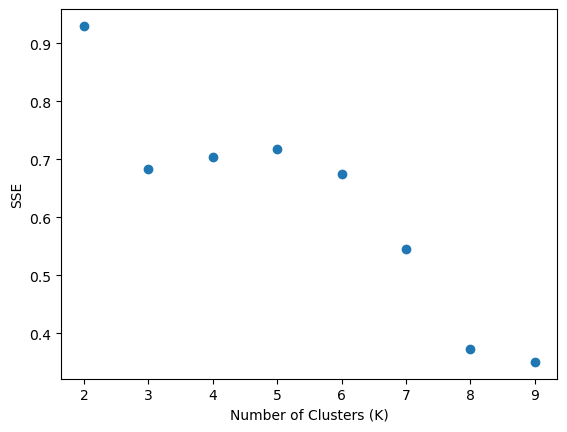

In [52]:
#根据手肘法判断聚类数量
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [57]:
#选择三类进行聚类
kmeans = KMeans(featuresCol='features',k=3)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         2|   12|
|         0|    8|
+----------+-----+



In [59]:
#预测结果展示
predictions=model.transform(final_data)
pandas_df = predictions.toPandas()
pandas_df

,_c0,active_number_sum,active_number_std,gas_sum,gas_std,value_sum,value_std,transaction_number_sum,transaction_number_std,features,prediction
0,DODO,-0.180677,-0.141251,-0.192666,-0.168807,-0.256726,-0.242553,0.304282,0.484572,"[-0.18067716316906726, -0.14125093963387347, -...",0
1,Open_sea,1.158003,0.733043,1.218200,0.787357,0.078852,-0.018480,0.974931,0.586944,"[1.1580027791230303, 0.733043079056282, 1.2182...",0
2,Uniswap,4.036123,4.178859,4.114562,4.239957,4.341107,4.350808,2.834858,3.331690,"[4.036122761904826, 4.1788589553411, 4.1145617...",1
3,Oasis_app,-0.427601,-0.391798,-0.336714,-0.314890,-0.283274,-0.269019,-0.942739,-0.899751,"[-0.42760113760627677, -0.3917978931874664, -0...",2
4,Shiba_swap,0.213520,0.335129,-0.172385,-0.128388,-0.283263,-0.269007,0.628432,1.047104,"[0.2135198965459931, 0.3351286614361221, -0.17...",0
5,Axie_infinity,0.283175,0.117049,-0.109731,-0.152698,-0.197977,-0.209320,1.017282,0.632678,"[0.2831750246137432, 0.11704911580821964, -0.1...",0
6,HEX,-0.224752,-0.202561,-0.279261,-0.261365,-0.154675,-0.151978,0.074670,0.138618,"[-0.2247517501466133, -0.20256133668869003, -0...",0
7,Rarible,-0.307338,-0.279579,-0.256543,-0.240082,-0.276522,-0.262872,-0.292939,-0.236627,"[-0.3073378363674129, -0.27957903174049087, -0...",2
8,Para_swap_io,-0.399484,-0.362726,-0.317129,-0.294658,-0.230925,-0.216107,-0.782687,-0.718761,"[-0.3994839698678494, -0.3627255634468228, -0....",2
9,Crypto_kitties,-0.294900,-0.299284,-0.275569,-0.272072,-0.276664,-0.264484,0.996155,0.575386,"[-0.29489984401391234, -0.2992842992057338, -0...",0
